In [ ]:
# default_exp samplers

# Samplers

> Collection of different samplers for sampling logical failure rates from quantum error correction circuits

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
#export
import qsam.math as math
from qsam.circuit import partition, make_hash
from qsam.simulators.chp import CHP
from qsam.fault_generators import Depolar, DepolarSS
from qsam.protocol import iterate

import numpy as np
import itertools as it
import networkx as nx

In [ ]:
#export
ONE_QUBIT_GATES = {'H', 'X', 'Z'}
TWO_QUBIT_GATES = {'CNOT'}

GATE_GROUPS = {'p': ONE_QUBIT_GATES | TWO_QUBIT_GATES,
               'p1': ONE_QUBIT_GATES,
               'p2': TWO_QUBIT_GATES }

map_dict = lambda d, map_fn: {k: map_fn(k,v) for k,v in d.items()} # apply map_fn to vals

In [ ]:
#export
class Sampler:
    def __init__(self, protocol, err_params):
        self.protocol = protocol
        self.p_phy_per_partition = np.vstack(list(err_params.values())).T
        self.partitions = map_dict(protocol._circuits, lambda _,circuit: [partition(circuit, GATE_GROUPS[g]) for g in err_params.keys()])
        self.fault_gens = map_dict(protocol._circuits, lambda _,circuit: Depolar(len(circuit)))
        
    def _sample(self, circuit_hash, p_or_w):
        partitions = self.partitions[circuit_hash]
        fault_gen = self.fault_gens[circuit_hash]
        fault_circuit = fault_gen.generate(partitions, p_or_w)
        circuit = self.protocol._circuits[circuit_hash]
        sim = CHP(circuit.n_qubits)
        msmt = sim.run(circuit, fault_circuit)
        return msmt
                         
    def run(self, n_samples, var=math.Wilson_var):
        fail_cnts = np.zeros((self.p_phy_per_partition.shape[0])) # one fail counter per p_phys
        
        for i, p_phy in enumerate(self.p_phy_per_partition):
            for _ in range(n_samples):
                p_it = iterate(self.protocol)
                node = next(p_it)
                
                while node:
                    if node == 'EXIT':
                        fail_cnts[i] += 1
                        break
                    else:
                        circuit_hash = self.protocol.circuit_hash(node)
                        msmt = self._sample(circuit_hash, p_phy)
                        node = p_it.send(msmt)
                    
        p_L = fail_cnts / n_samples
        std = np.sqrt( var(p_L, n_samples) )
        return p_L, std

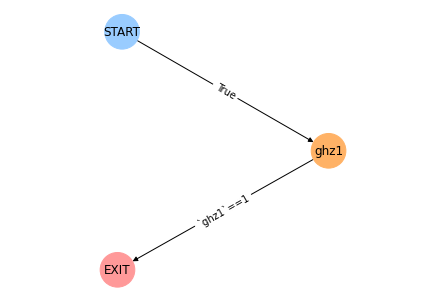

In [ ]:
from qsam.protocol import Protocol, draw_protocol, iterate
from qsam.circuit import Circuit

ghz = Circuit([ {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}   ])

ghz1 = Protocol()
ghz1.add_nodes_from(['ghz1'], circuits=ghz)
ghz1.add_edge('START', 'ghz1', check='True')
ghz1.add_edge('ghz1', 'EXIT', check='`ghz1`==1')
draw_protocol(ghz1)

In [ ]:
#slow

p = np.logspace(-3,0,10)
err_params = {'p': p}

sam = Sampler(ghz1, err_params)
p_L, std = sam.run(n_samples=10000)

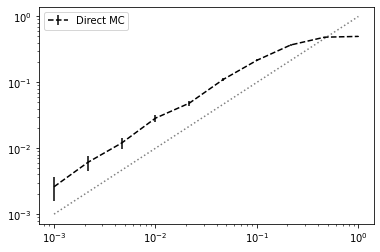

In [ ]:
#hide_input
#slow

import matplotlib.pyplot as plt

plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

In [ ]:
#hide
#export
def calc_w_max(p_max, delta_max, n_partition_elems):
    """Calculate weight cutoff at p_max for delta_max"""
    
    delta = 1
    for w_max in range(n_partition_elems+1):
        delta -= math.binom(w_max, n_partition_elems, p_max)
        if delta < delta_max: 
            break
    return w_max

def calc_subset_occurances(partitions, partition_w_vecs, p_phy_per_partition):
    """Return (weight)x(p_phys) (parition) subset occurance matrix transforming a p_SS vector to a p_L vector"""
    
    n_partition_elems = np.array([len(p) for p in partitions])
    Aws = np.array([math.binom(w_vec, n_partition_elems, p_phy_per_partition) for w_vec in partition_w_vecs])
    Aws = np.product(Aws, axis=-1) # mult Aws for multi-parameter, i.e. multi-partitions
    return Aws

For the subset sampler we want to sample from specific fault-weight-subsets upto a certain maximum weight $w_{max}$. The benefit of this approach is that we can scale each of the resulting failure rates by analytically calculated `subset_occurances` for each `p_phy` which then gives us `p_L(p_phy)` for all `p_phy` without any additional sampling required. The subset sampler chooses the next fault-weight subset that is used when sampling from the next circuit in the protocol by the minimum sampled subset for a given circuit, which results in a balanced sampling over all subsets for a circuit. Additionally, one can exclude sampling for all circuits in a protocol from certain subsets by specifying a *list of ints* of `w_exclude` fault-weights. Overall, this approach of choosing the subsets and defining the weight threshold is not ideal. The dynamic subset sampler includes methods to improve on both of these points.

In [ ]:
#export
class SubsetSampler(Sampler):
    """Subset Sampler of quantum protocols"""
    
    def __init__(self, protocol, err_params):
        super().__init__(protocol, err_params)
        self.fault_gens = map_dict(protocol._circuits, lambda _,circuit: DepolarSS(len(circuit)))
    
    def analytics(self, w_maxs, w_exclude={}):
        w_exclude = set((w,) if isinstance(w,int) else w for w in w_exclude)
        w_maxs = [w_maxs] if isinstance(w_maxs, int) else w_maxs

        w_upto_w_maxs = {c_hash: [tuple(range(w_max+1)) for w_max in w_maxs] for c_hash in self.protocol._circuits.keys()} # order [p1,p2,..]
        w_vecs = map_dict(w_upto_w_maxs, lambda _,w_list: [w_vec for w_vec in it.product( *w_list ) if w_vec not in w_exclude])
        Aws = map_dict(w_vecs, lambda c,w: calc_subset_occurances(self.partitions[c], w, self.p_phy_per_partition))
        return Aws, w_vecs
    
    def run(self, n_samples, w_max, w_exclude={}, var=math.Wilson_var):
         
        Aws, w_vecs = self.analytics(w_max, w_exclude)
        
        d = {n:c for n,c in self.protocol.nodes.data("circuit_hash", default=None) if c}
        visited_cnts     = map_dict(d, lambda _,c_hash: np.zeros(len(w_vecs[c_hash])))
        transition_cnts = map_dict(d, lambda node,c_hash: {s: np.zeros(len(w_vecs[c_hash])) for s in self.protocol.successors(node)})
                
        for _ in range(n_samples):
            hist = [] # track all (node,weight)s for a protocol run
            p_it = iterate(self.protocol)
            node = next(p_it)
            
            while node:
                if node == "EXIT":
                    break
                else:
                    circuit_hash = self.protocol.circuit_hash(node)
                    w_idx = visited_cnts[node].argmin() # balanced weight selector
                    w = w_vecs[circuit_hash][w_idx]
                    hist.append((node,w_idx))
                    msmt = self._sample(circuit_hash, w)
                    visited_cnts[node][w_idx] += 1
                    _node = node # store prev node
                    node = p_it.send(msmt) # exchange with iterator
                    if node: # None: insignificant exit -> no transition
                        transition_cnts[_node][node][w_idx] += 1  
        
        # Calculate statistics
        
        pws = {n: {succ: tcnts / visited_cnts[n] for succ,tcnts in ntrans.items()} for n,ntrans in transition_cnts.items()} 
        unpack_node = lambda n: n if not isinstance(n,(tuple,list,set)) else n[0]
        
        # p_L
        fail_paths = list(nx.all_simple_paths(self.protocol, 'START', 'EXIT'))
        Aws_wo_excl, w_vecs_wo_excl = self.analytics(w_max, {})
        p_L_up, p_L_low = 0, 0
        for path in fail_paths:
            p_L_up_prod_acc = 1
            p_L_low_prod_acc = 1
            for i in range(1,len(path)-1):
                node, succ_node = path[i:i+2]
                circuit_hash = self.protocol.circuit_hash(node)
                pw = np.sum([Aws[circuit_hash][w] * pws[node][succ_node][w] for w in range(len(w_vecs[circuit_hash]))], axis=0)
                deltas = 1 - np.sum([Aws_wo_excl[circuit_hash][w] for w in range(len(w_vecs_wo_excl[circuit_hash]))], axis=0)
                p_L_low_prod_acc *= pw
                p_L_up_prod_acc *= (pw + deltas)
            p_L_up += p_L_up_prod_acc
            p_L_low += p_L_low_prod_acc
            
        # v_L
        v_L = 0
        for n1, p_to in pws.items(): # for every node in pws
            c_hash = self.protocol.circuit_hash(n1)
            for succ_node, ps in p_to.items(): # get the pws
                for w_idx, pw in enumerate(ps): # get pw per node
                    
                    vw = var(pw, visited_cnts[n1][w_idx]) # calc. V[pw]
                    Aw = Aws[c_hash][w_idx] # calc. Aw for a single node
                    
                    sum_acc = 0 # sum over all fail paths
                    for path in fail_paths:
                        prod_acc = 1
                        for i in range(1,len(path)-1): # all nodes in a fail path
                            n2, n2_succ = path[i:i+2] 
                            if n1 != n2: 
                                c_hash2 = self.protocol.circuit_hash(n2)
                                prod_acc *= np.sum([Aws[c_hash2][w] * pws[n2][n2_succ][w] for w in range(len(w_vecs[c_hash2]))], axis=0)
                        sum_acc += prod_acc
                        
                    v_L += vw * Aw**2 * sum_acc**2
                    
        return p_L_up, p_L_low, np.sqrt(v_L)

In [ ]:
#slow
p = np.logspace(-3,0,10)
err_params = {'p': p}

sam = SubsetSampler(ghz1, err_params)
p_L_up,p_L_low,ss_std = sam.run(n_samples=1000, w_max=[2], w_exclude=[]) # params w_max, w_exclude are applied to all circuits in the protocol

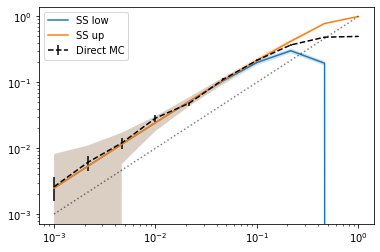

In [ ]:
#hide_input
#slow

import matplotlib.pyplot as plt

plt.errorbar(p, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p, p_L_low, label="SS low")
plt.fill_between(p, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)
plt.plot(p, p_L_up, label="SS up")
plt.fill_between(p, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

# NOTE: when we not exlcude w=0, its contribution to the variance gives rise to large uncertainty for lower p_phy.

plt.plot(p, p, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

The dynamic subset sampling approach now extends the subset sampler by:
1. Including a function to dynamically choose the next circuit's subset weight to sample from such that the global variance $V_L$ is reduced most.
2. A method to choose all subset weights for each circuit which we want to include in the sampling process, s.t. its overall occurance is smaller than a user-defined threshold $\chi_{min}$.

# Multi-parameter/partition noise
Similarly, for a multi-parameter noise model all we have to do is specify the physical error rates for corresponding partitions and pass it to the sampler. Note that for now only two partitions are implemented (one for one-qubit gates and one for two-qubit gates).

In [ ]:
#slow
p1 = np.logspace(-3,0,10)
p2 = 0.5 * p1
err_params = {'p1': p1, 'p2': p2}

sam = SubsetSampler(ghz1, err_params)
p_L_up, p_L_low, ss_std = sam.run(n_samples=1000, w_max=[1,3], w_exclude=[(0,0)])

sam = Sampler(ghz1, err_params)
p_L, std = sam.run(n_samples=10000)

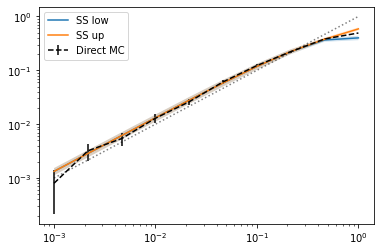

In [ ]:
#hide_input
#slow

import matplotlib.pyplot as plt

plt.errorbar(p1, p_L, fmt='--', c="black", yerr=std, label="Direct MC")

plt.plot(p1, p_L_low, label="SS low")
plt.fill_between(p1, p_L_low-ss_std, p_L_low+ss_std, alpha=0.2)
plt.plot(p1, p_L_up, label="SS up")
plt.fill_between(p1, p_L_up-ss_std, p_L_up+ss_std, alpha=0.2)

plt.plot(p1, p1, 'k:', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend();

In [ ]:
show_doc(calc_w_max)

<h4 id="calc_w_max" class="doc_header"><code>calc_w_max</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>calc_w_max</code>(**`p_max`**, **`delta_max`**, **`n_partition_elems`**)

Calculate weight cutoff at p_max for delta_max

Let's look at how $w_{max}$ is selected for differen $p_{max}$ and $\delta_{max}$.

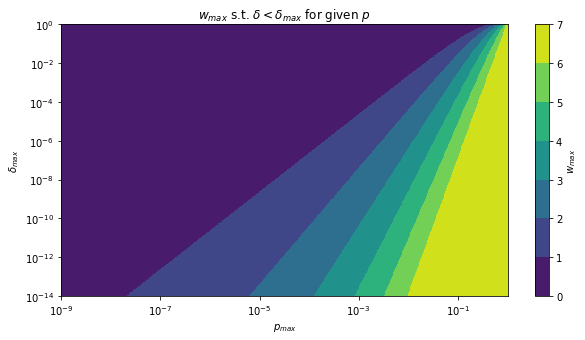

In [ ]:
#slow
#hide_input

n_gates = len(ghz)

ps = np.logspace(-9, 0, 500) # physical error rates
ds = np.logspace(-14, 0, 500)

Z = [[calc_w_max(p_max, d_max, n_gates) for p_max in ps] for d_max in ds]

plt.figure(figsize=(10,5))
plt.contourf(ps, ds, Z)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p_{max}$')
plt.ylabel('$\delta_{max}$')
plt.colorbar(label="$w_{max}$")
plt.title('$w_{max}$ s.t. $\delta<\delta_{max}$ for given $p$');
plt.show()

In [ ]:
show_doc(calc_subset_occurances)

<h4 id="calc_subset_occurances" class="doc_header"><code>calc_subset_occurances</code><a href="__main__.py#L13" class="source_link" style="float:right">[source]</a></h4>

> <code>calc_subset_occurances</code>(**`partitions`**, **`partition_weight_vecs`**, **`p_phys_mat`**)

Calculate 3D tensor of binom. coefficients for each partition

Let's take a look at how the subset occurance for the GHZ circuit changes for the single parameter case and for varying physical error rates

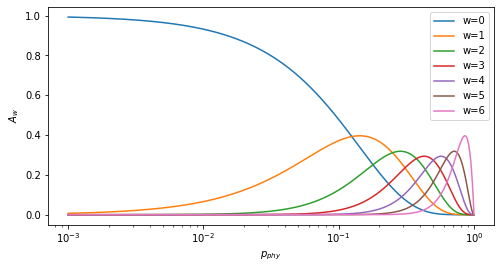

In [ ]:
#hide_input
#slow

n = 1000
p_phy = np.logspace(-3, 0, n)

part = partition(ghz, GATE_GROUPS['p'])
Aw = np.array([[math.binom(w, len(part)+1, p) for p in p_phy] for w in range(len(part)+1)])
plt.figure(figsize=(8,4))
plt.plot(p_phy, Aw.T, label=[f'w={i}' for i in range(len(part)+1)]);
plt.xlabel(r'$p_{phy}$');
plt.ylabel(r'$A_w$');
plt.xscale('log');
plt.legend();

We can clearly see that the larger weight subsets only become relevant for relatively large physical error rates. We also see that the 0-fault-weight subset becomes enourmously relevant at low $p_{phy}$, so we gain a lot by excluding it.

And for the multi-parameter case:

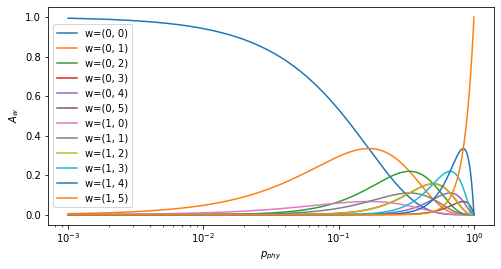

In [ ]:
#hide_input
#slow

n = 1000
p_phy = np.logspace(-3, 0, n)

err_params = {'p1':p_phy, 'p2':p_phy}
partitions = [partition(ghz, GATE_GROUPS[g]) for g in err_params.keys()]
p_phys_mat = np.vstack(list(err_params.values())).T # p_phy_range x partitions
w_max_vec = [len(p) for p in partitions]
w_upto_w_maxs = [tuple(range(w_max+1)) for w_max in w_max_vec]
w_vecs = list(it.product( *w_upto_w_maxs ))
Aws = calc_subset_occurances(partitions, w_vecs, p_phys_mat)

plt.figure(figsize=(8,4))
plt.plot(p_phy, Aws.T, label=[f'w={i}' for i in w_vecs]);
plt.xlabel(r'$p_{phy}$');
plt.ylabel(r'$A_w$');
plt.xscale('log');
plt.legend();